In [1]:
import pickle as pkl
import time
import os
import numpy as np
import sys
from music21 import instrument, note, corpus, converter, stream, chord, duration
#from models.LTSM import new_nn, sampling
import matplotlib.pyplot as plt
import glob
from keras.layers import LSTM, Input, Multiply,Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, Softmax,RepeatVector, Permute, Lambda, TimeDistributed
import keras.backend as K 
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Parameters Initialization

In [2]:
parent_folder = 'New_Music' #Set up the data folders
run_num = '0001'
track_name = 'Tracks'
folder_in = 'run/{}/'.format(parent_folder)
folder_in += '_'.join([run_num, track_name])


embedding_size = 100
recurr_neural_network_units = 256
attention_usage = True


## Loading the "diff_ones" and "all_combined" files

In [3]:

storage = os.path.join(folder_in, 'data_storage')  

with open(os.path.join(storage, 'diff_ones'), 'rb') as filepath:
    diff_ones = pkl.load(filepath)
    pitch, pitch_num, time_step, timestep_num = diff_ones

with open(os.path.join(storage, 'all_combined'), 'rb') as filepath:
    all_combined = pkl.load(filepath)
    pitch_numerical, numerical_pitch, timestep_numerical, numerical_timestep = all_combined
print(timestep_numerical)

{0: 0, Fraction(1, 12): 1, Fraction(1, 6): 2, 0.25: 3, Fraction(1, 3): 4, Fraction(5, 12): 5, 0.5: 6, Fraction(7, 12): 7, Fraction(2, 3): 8, 0.75: 9, 1.0: 10, 1.25: 11, 1.5: 12, 2.0: 13}


## Model to predict

In [4]:
weights_in = os.path.join(folder_in, 'weights_record') #Weights were loaded from weights_record file.
weights_doc = 'weights_record.h5'

pitch_in = Input(shape = (None,))
timestep_in = Input(shape = (None,))

pitch_layer = Embedding(pitch_num, embedding_size)(pitch_in)
time_step_layer = Embedding(timestep_num, embedding_size)(timestep_in) 

nn_layers = Concatenate()([pitch_layer,time_step_layer])

nn_layers = LSTM(recurr_neural_network_units, return_sequences=True)(nn_layers)
#nn_layers = Dropout(0.3)(nn_layers)

if attention_usage==False:
    final_layer = LSTM(recurr_neural_network_units)(nn_layers)

    
else:
    nn_layers = LSTM(recurr_neural_network_units, return_sequences=True)(nn_layers)
 #   nn_layers = Dropout(0.2)(nn_layers)

    dense_layer = Dense(1, activation='tanh')(nn_layers)
    dense_layer = Reshape([-1])(dense_layer)
    alpha = Activation('softmax')(dense_layer)

    alpha_2 = Permute([2, 1])(RepeatVector(recurr_neural_network_units)(alpha))

    final_layer = Multiply()([nn_layers, alpha_2])
    final_layer = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(recurr_neural_network_units,))(final_layer)
    
    
  #  final_layer = Dropout(0.2)(final_layer)
                                    
pitch_out = Dense(pitch_num, activation = 'softmax', name = 'pitch')(final_layer)
timesteps_out = Dense(timestep_num, activation = 'softmax', name = 'timseteps')(final_layer)
   
model = Model([pitch_in, timestep_in], [pitch_out, timesteps_out])
    

if attention_usage==False:
    model_with_attention = None
else:
    model_with_attention = Model([pitch_in, timestep_in], alpha)


#model, model_with_attention = new_nn(pitch_num, timestep_num, embedding_size, recurr_neural_network_units, attention_usage)
source = os.path.join(weights_in,weights_doc)
model.load_weights(source)
model.summary()

W0505 21:35:10.344361 20388 deprecation_wrapper.py:119] From C:\Users\Arjun\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0505 21:35:10.358364 20388 deprecation_wrapper.py:119] From C:\Users\Arjun\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0505 21:35:10.362399 20388 deprecation_wrapper.py:119] From C:\Users\Arjun\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0505 21:35:11.198478 20388 deprecation_wrapper.py:119] From C:\Users\Arjun\anaconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session in

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    23300       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1400        input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

## Build your own phrase

In [5]:

pitches_temp=0.5
time_steps_temp = 0.5
maximum_pitches = 50
max_sequence_length = 32
sequence_length = 32
si=1
pitches = ['START']
time_steps = [0]
pitch_len = len(pitches)
time_step_len = len(time_steps)
if sequence_length is not None:
    pitches = ['START'] * (sequence_length - pitch_len) + (pitches)
    time_steps = [0] * (sequence_length - time_step_len) + (time_steps)


sequence_length = len(pitches)
print(time_steps)
print(len(time_steps))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
32


## LSTM model generating pitches and timesteps

In [6]:
op = []
pitches_ip_seq = []
timestep_ip_seq = []
si=1
predictions = []

for n, d in zip(pitches,time_steps):
    pitch_num_int = pitch_numerical[n]   #Look up the integer codes for pitches and time steps and add them to th einput sequence
    time_step_int = timestep_numerical[d]
    
    pitches_ip_seq.append(pitch_num_int)
    timestep_ip_seq.append(time_step_int)  
    
    op.append([n, d])   #Concatenate the pitches and time steps.
    
    if n != 'START':     #If the pitches is not the starting pitch
        result_pitches = note.Note(n)    #Store the Notes of the particular pitch in results_pitches

        new_pitch = np.zeros(128)
        new_pitch[result_pitches.pitch.midi] = si 
        predictions.append(new_pitch)
#print(predictions)
#print(predictions)
first_matrix = np.zeros(shape = (maximum_pitches+sequence_length, maximum_pitches))  #Initialize a matrix for attention mechanism
print(timestep_ip_seq)
for pitch_ix in range(maximum_pitches):#Loop over the extra pitches

    pred_ip = [
        np.array([pitches_ip_seq])     
        , np.array([timestep_ip_seq])
       ]                    #Prediction input consists of pitch and time step sequences
    print(pred_ip)

    pitch_pred, timestep_preds = model.predict(pred_ip, verbose=0)    #Predict the pitches and time steps.
    print(pred_ip)
    if attention_usage==True:
        attention_preds = model_with_attention.predict(pred_ip, verbose=0)[0] #If attention mechanism is used, then use attention model to predict.
        first_matrix[(pitch_ix-len(attention_preds)+sequence_length):(pitch_ix+sequence_length), pitch_ix] = attention_preds
    
    new_pitch = np.zeros(128)  
    
    for idx, n_i in enumerate(pitch_pred[0]):
        try:
            pitch = numerical_pitch[idx]
            result_pitches = note.Note(pitch)
            new_pitch[result_pitches.pitch.midi] = n_i   #Newly created pitches in new_pitch array from the predicted result.
            
        except:
            pass
        
    predictions.append(new_pitch)
      
    if pitches_temp == 0:
        input1= np.argmax(pitch_pred[0])
    else:
        pitch_pred[0] = np.log(pitch_pred[0]) / pitches_temp
        preds_exp = np.exp(pitch_pred[0])
        pitch_pred[0] = preds_exp / np.sum(preds_exp)
        input1 =  np.random.choice(len(pitch_pred[0]), p=pitch_pred[0])
    if time_steps_temp == 0:
        input2= np.argmax(timestep_preds[0])
    else:
        timestep_preds[0] = np.log(timestep_preds[0]) / time_steps_temp
        preds_exp1 = np.exp(timestep_preds[0])
        timestep_preds[0] = preds_exp1 / np.sum(preds_exp1)
        input2= np.random.choice(len(timestep_preds[0]), p=timestep_preds[0])
    
    
    pitch_op = numerical_pitch[input1]    #Sampling the predicted pitches and time steps and controlling the variations with the temperary varaibles
    timestep_op = numerical_timestep[input2]
    
    op.append([pitch_op, timestep_op]) #Concatenating the outputs
    #print(timestep_op)
    pitches_ip_seq.append(input1)
    timestep_ip_seq.append(input2)
    
    if len(pitches_ip_seq) > max_sequence_length:
        pitches_ip_seq = pitches_ip_seq[1:]
        timestep_ip_seq = timestep_ip_seq[1:]
        
#     print(pitch_op)
#     print(timestep_op)
        
    if pitch_op == 'START':
        break
print(pitch_pred)
predictions = np.transpose(np.array(predictions)) 
print('Total Number of pitch sequences'.format(len(op)))  #Generated notes

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 232]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 232]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232,
        232, 232, 232, 232, 232, 172]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 172, 126,
        227, 166, 195, 172, 195, 227,  11,  38,  11,  11, 227, 107, 227,
        227, 126,  11, 227, 107, 195]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 172, 126, 227,
        166, 195, 172, 195, 227,  11,  38,  11,  11, 227, 107, 227, 227,
        126,  11, 227, 107, 195,  11]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 172, 126, 227,
        166, 195, 172, 195, 227,  11,  38,  11,  11, 227, 107, 227, 227,
        126,  11, 227, 107, 195,  11]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[232, 232, 232, 232, 232, 232, 232, 232, 232, 172, 126, 227, 166,
        195, 172,

        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[ 38,  11,  11, 227, 107, 227, 227, 126,  11, 227, 107, 195,  11,
         11, 107, 195, 126, 227,  11, 126, 126, 126,  38, 126, 126,  81,
        126, 126, 126, 126, 126, 126]]), array([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[ 11,  11, 227, 107, 227, 227, 126,  11, 227, 107, 195,  11,  11,
        107, 195, 126, 227,  11, 126, 126, 126,  38, 126, 126,  81, 126,
        126, 126, 126, 126, 126, 126]]), array([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[ 11,  11, 227, 107, 227, 227, 126,  11, 227, 107, 195,  11,  11,
        107, 195, 126, 227,  11, 126, 126, 126,  38, 126, 126,  81, 126,
        126, 126, 126, 126, 126, 126]]), array([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])]
[array([[ 11, 227, 107, 227, 227, 126,  11, 227, 1

Text(0, 0.5, 'pitches')

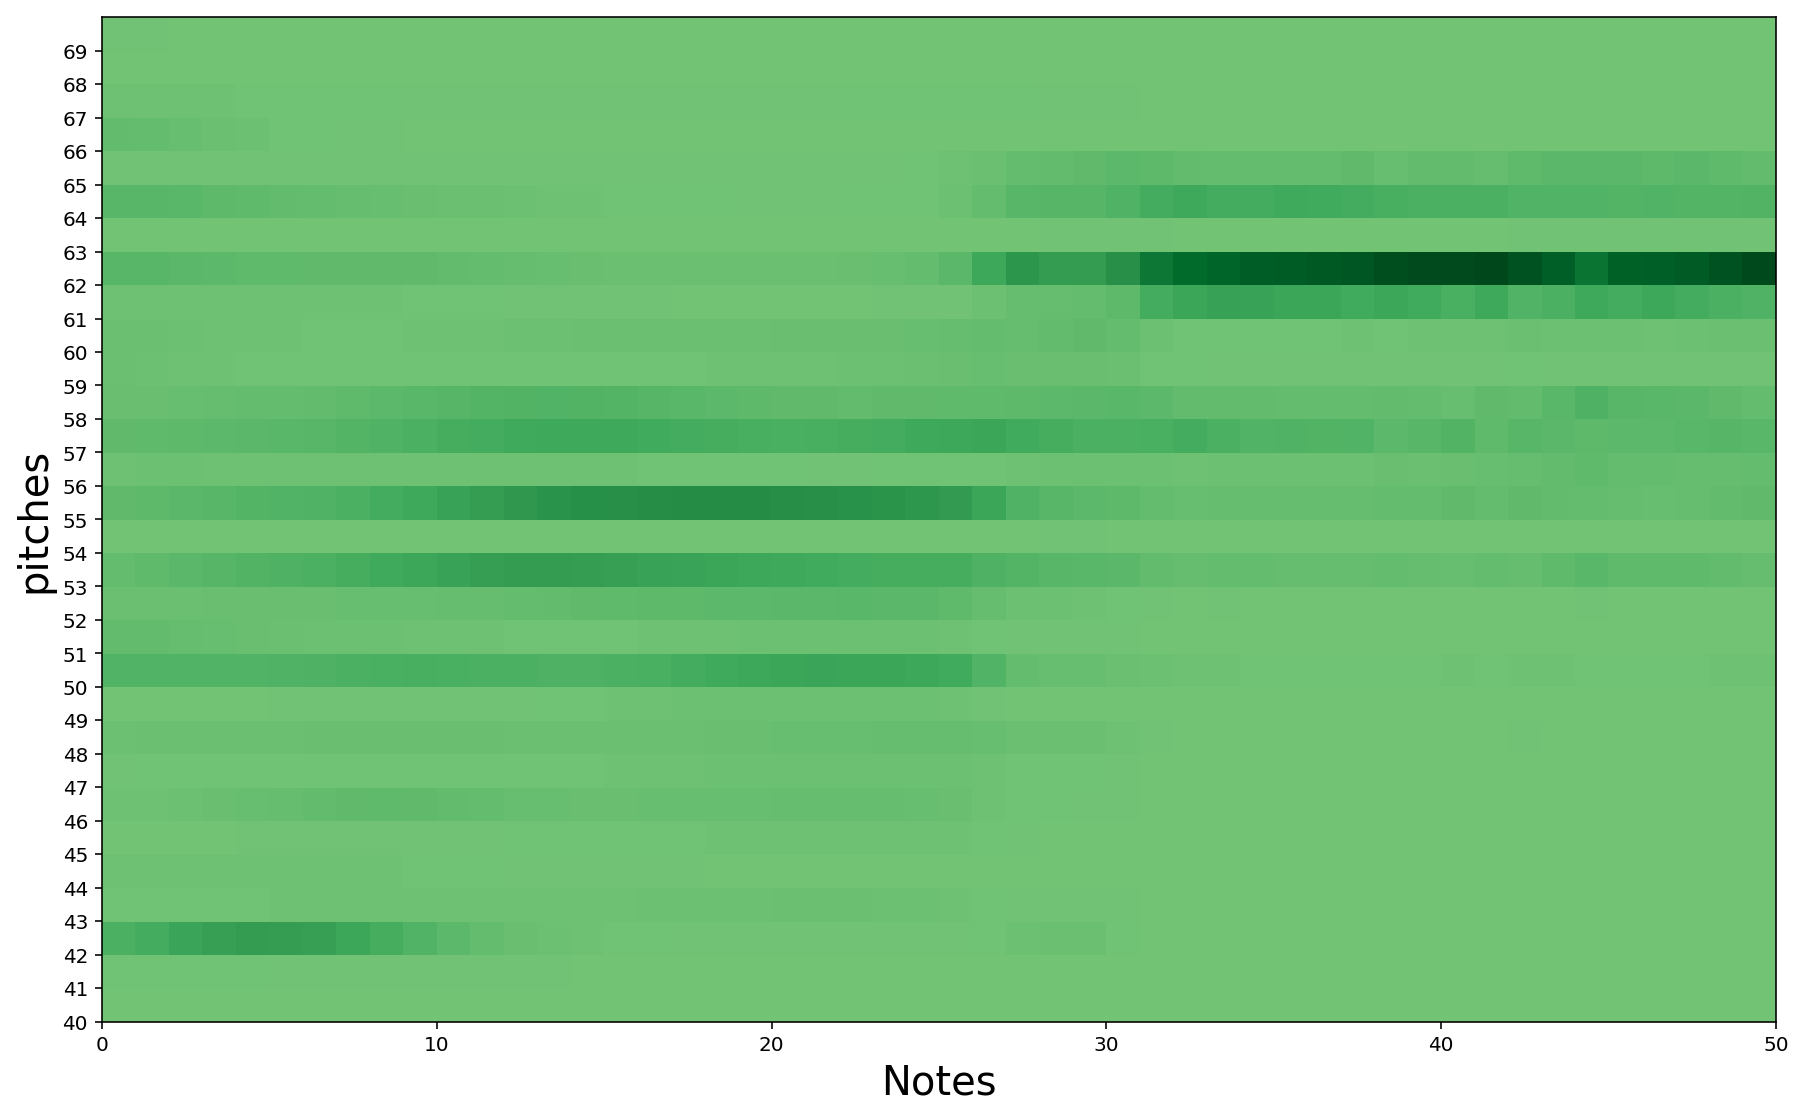

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(40,70)])
ax. xaxis. label. set_size(20)
ax. yaxis. label. set_size(20)
plt.imshow(predictions[40:70,:], origin="lower", cmap='Greens', vmin = -0.5, vmax = 0.5, extent=[0, maximum_pitches,40,70]
          
          )
plt.xlabel('Notes')
plt.ylabel('pitches')

## Conversion of pitches and timesteps to midifiles. 

In [8]:
op_folder = os.path.join(folder_in, 'output_tracks')

op_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for p in op:
    pitch_p, time_step_p = p
    # pattern is a chord
    if ('.' in pitch_p):
        pitch_stream = pitch_p.split('.')
        chord_pitch = []
        for current_note in pitch_stream:
            new_pitch = note.Note(current_note)
            new_pitch.duration = duration.Duration(time_step_p)
            new_pitch.storedInstrument = instrument.Violoncello()
            chord_pitch.append(new_pitch)
        new_chord = chord.Chord(chord_pitch)
        op_stream.append(new_chord)
    elif pitch_p != 'START':
    # pattern is a note
        new_pitch = note.Note(pitch_p)
        new_pitch.duration = duration.Duration(time_step_p)
        new_pitch.storedInstrument = instrument.Violoncello()
        op_stream.append(new_pitch)
    elif pitch_p == 'rest':
    # pattern is a rest
        new_pitch = note.Rest()
        new_pitch.duration = duration.Duration(time_step_p)
        new_pitch.storedInstrument = instrument.Violoncello()
        op_stream.append(new_pitch)
    



op_stream = op_stream.chordify()

op_stream.write('midi', fp=os.path.join(op_folder, 'output-' + time.strftime("%Y%m%d-%H%M%S") + '.mid'))

'run/New_Music/0001_Tracks\\output_tracks\\output-20210505-213513.mid'

In [9]:
print(duration)

<module 'music21.duration' from 'C:\\Users\\Arjun\\anaconda3\\envs\\generative\\lib\\site-packages\\music21\\duration.py'>


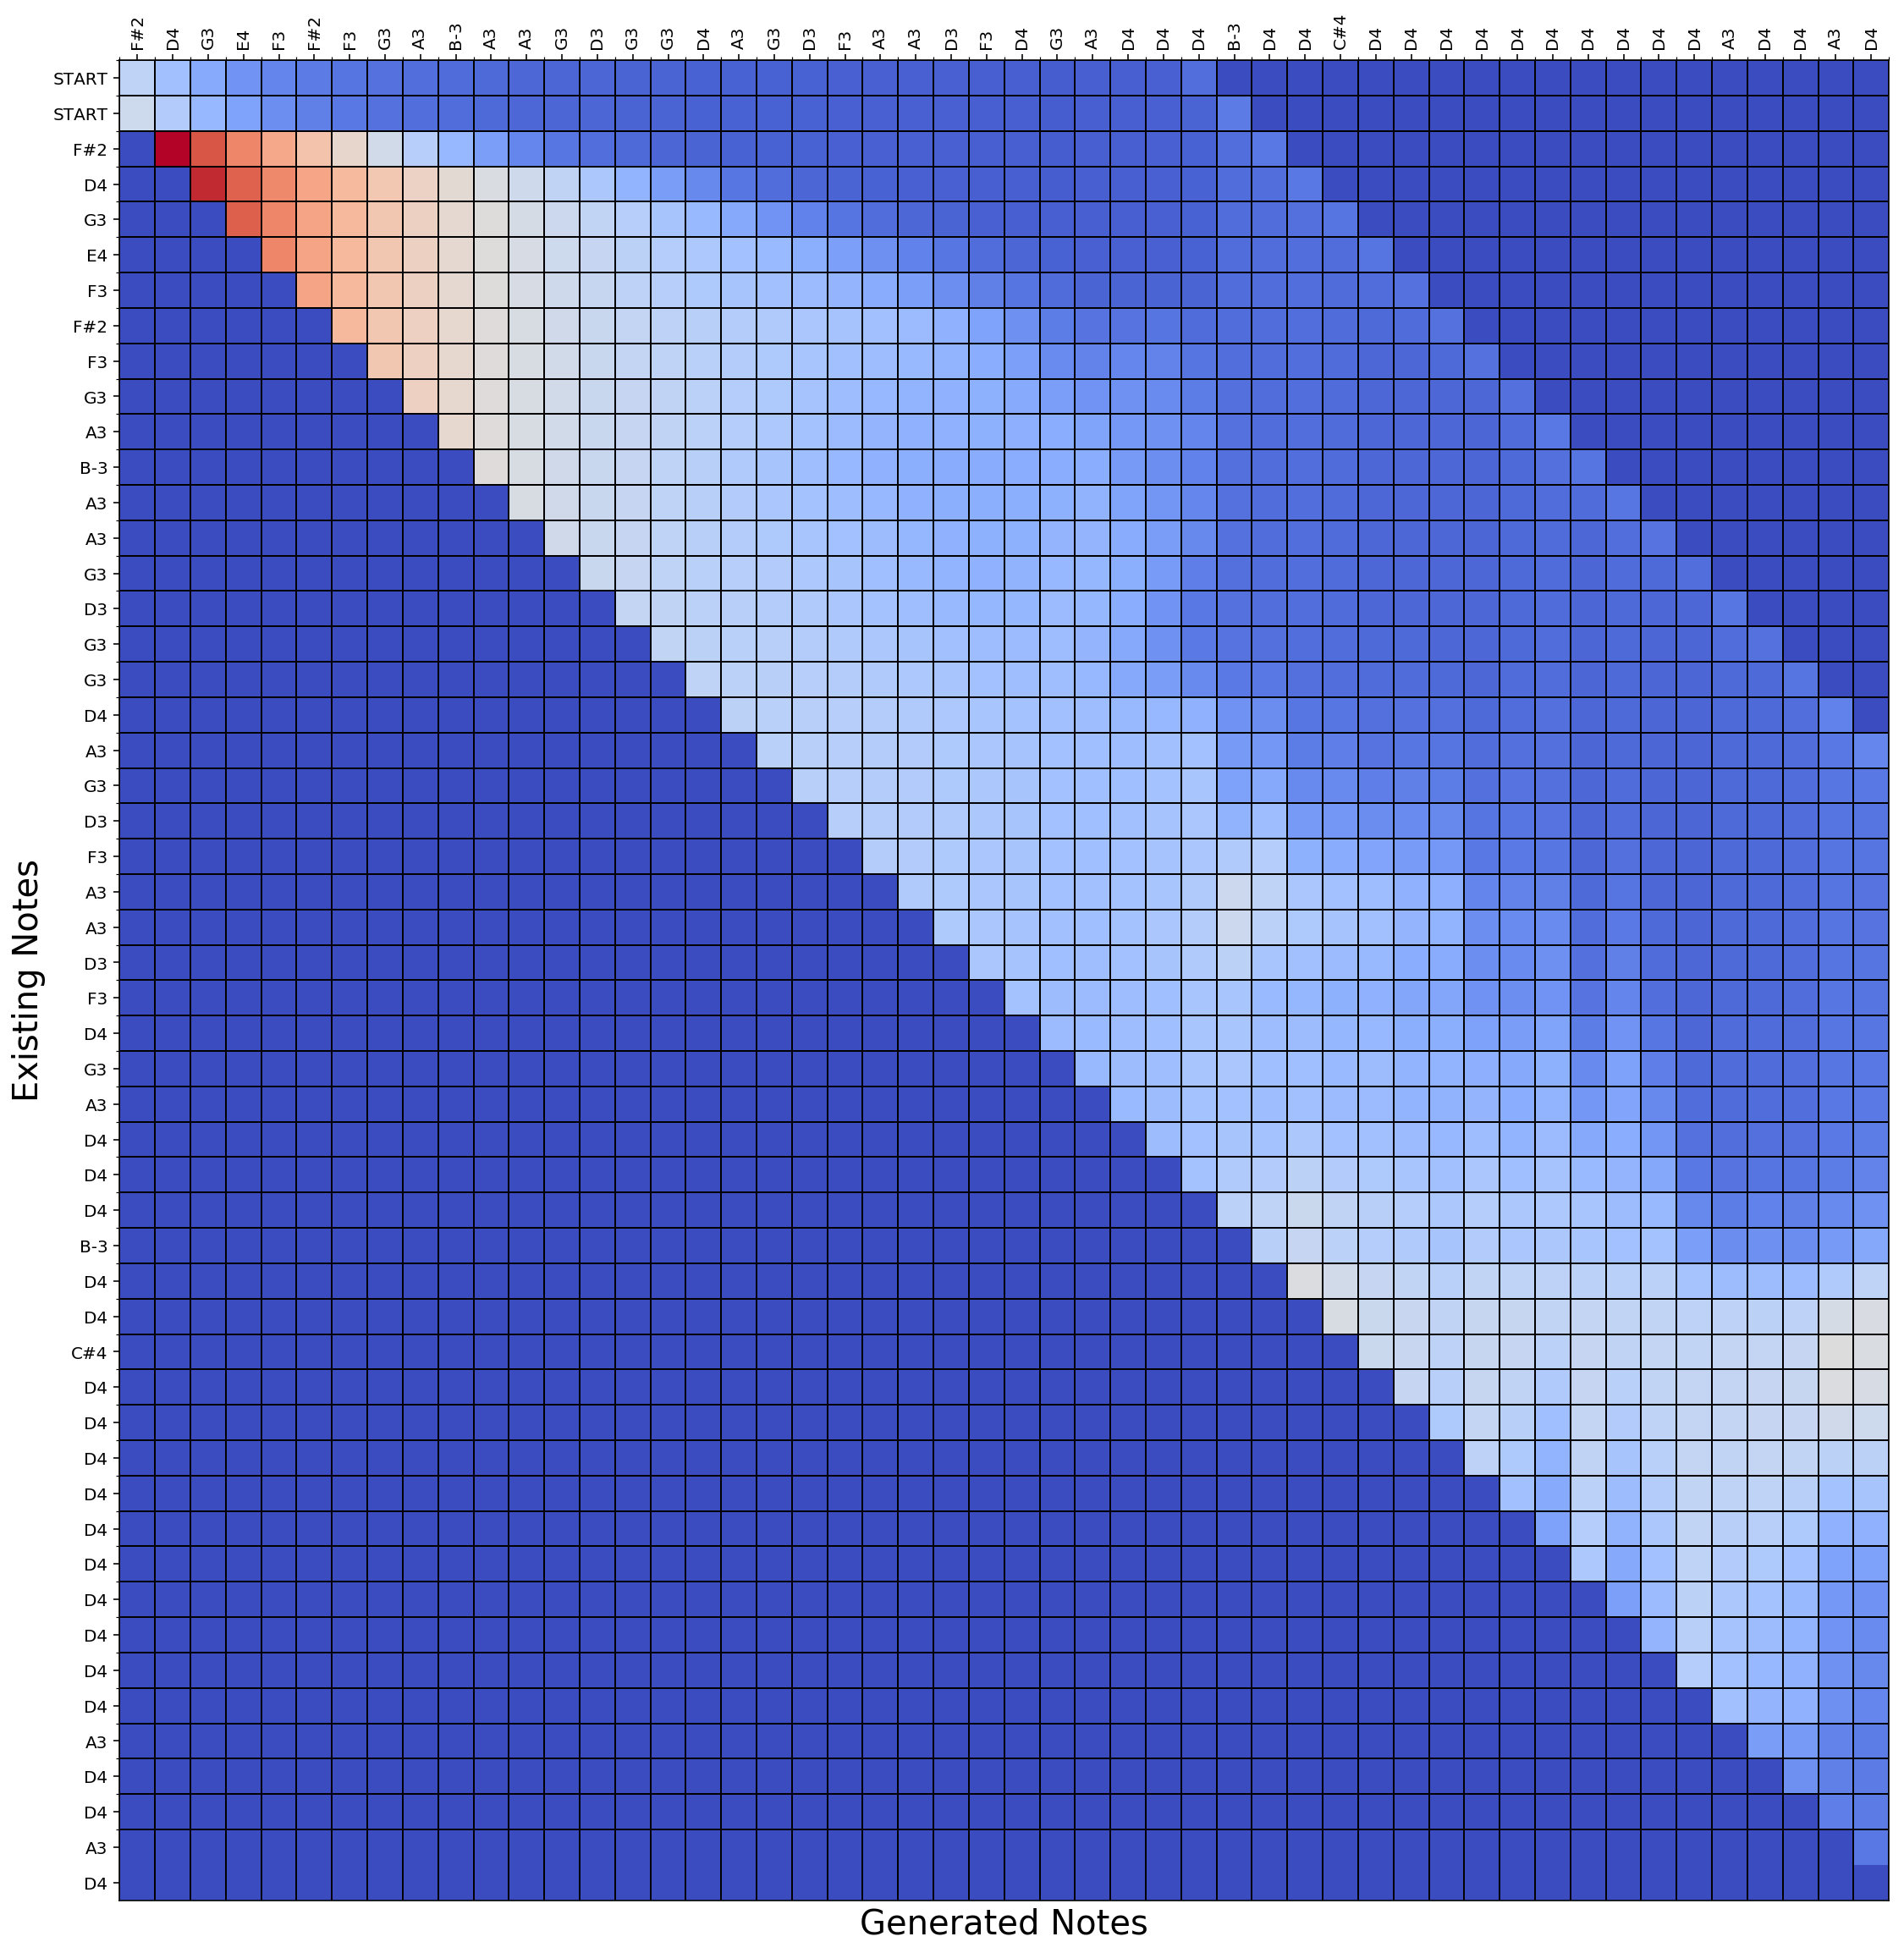

In [10]:
## attention plot
if attention_usage==True:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(first_matrix[(sequence_length-2):,], cmap='coolwarm', interpolation='nearest')


    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(op)- sequence_length, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(op)- sequence_length, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(op) - sequence_length))
    ax.set_yticks(np.arange(len(op)- sequence_length+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in op[(sequence_length):]])
    ax.set_yticklabels([n[0] for n in op[(sequence_length - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()
    ax. xaxis. label. set_size(20)
    ax. yaxis. label. set_size(20)
    figsize=(15,15)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")
    plt.xlabel('Generated Notes')
    plt.ylabel('Existing Notes')
    plt.show()